# Training diffusion models

In this notebook, we present an introduction to Denoising Diffusion Models
We aim for simplicity so as to appeal and will not deal with the engineering technicalities.
Most of the functions of this notebook are simpler versions than the ones used in the wild.
This notebook is structured as follows.

<!-- TOC -->

- [Training diffusion models](#training-diffusion-models)
  - [Creating datasets](#creating-datasets)
  - [Creating the Ornstein-Uhlenbeck process](#creating-the-ornstein-uhlenbeck-process)
  - [Investigating the forward diffusion](#creating-the-diffusion-datasets)
  - [Creating the model, loss and optimizer](#creating-the-model-loss-and-optimizer)
  - [Training the model](#training-the-model)   
  - [Sampling from the model](#sampling-from-the-model)
  - [Onto image datasets](#onto-image-datasets)

<!-- /TOC -->

This codebase is inspired from  <https://github.com/yang-song/score_sde>.

In this notebook we use the JAX framework. We use the `haiku` package to handle networks and the `optax` package to handle optimization.

For each cell, what you have to fill is marked with a `TODO`.

## Useful functions

A cell of useful functions used throughout the code. Can be omitted at first read.

In [ ]:
import jax
import numpy as np
from itertools import repeat

def batch_mul(a, b):
    return jax.vmap(lambda a, b: a * b)(a, b)


def batch_div(a, b):
    return jax.vmap(lambda a, b: a / b)(a, b)


def numpy_collate(batch):
    """Collate function for numpy arrays (see https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html)."""
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(np.array(samples)) for samples in transposed]


def repeater(data_loader):
    for loader in repeat(data_loader):
        for data in loader:
            yield data


In [ ]:
!pip install hk


ERROR: Could not find a version that satisfies the requirement hk (from versions: none)
ERROR: No matching distribution found for hk


## Training diffusion models

Diffusion models are a powerful class of generative models.
The following introduction of Diffusion models rely on the Stochastic Differential Equation(SDE) formalism. First, consider a *forward noising* process

$\mathrm{d} \mathbf{X}_t = - (1/2) \mathbf{X}_t \mathrm{d} t + \mathrm{d} \mathbf{B}_t, \qquad \mathbf{X}_0 \sim \pi \
    .$

This process progressively adds noise to the data so as to for large value of $t$, $\mathbf{X}_t$ is close to a Gaussian. The goal is then to *reverse* that process by considering a *backward denoising* process, $(\mathbf{Y}_t)_{t \in [0, T]} = (\mathbf{X}_{T-t})_{t \in [0, T]}$. It is remarkable that this process also satisfies a SDE given by

$\mathrm{d} \mathbf{Y}_t = \{(1/2) \mathbf{Y}_t + \nabla \log p_{T-t}(\mathbf{Y}_t)\}\mathrm{d} t + \mathrm{d} \mathbf{B}_t, \qquad \mathbf{Y}_0 \sim \pi_T, $

where $p_t$ is the density of $\mathbf{X}_t$. $\nabla \log p_t$ is called the *score*. In practice we approximate this backward dynamics by:
* Discretizing the backward SDE using the Euler-Maruyama integrator.
* Sampling from $\mathbf{Y}_0 \sim \mathrm{N}(0, \mathrm{Id})$ instead of $\mathbf{Y}_0 \sim \pi_T$.
* Approximating the score leveraging techniques from score-matching and deep learning.


### Creating datasets

Back to the [top](#diffusion-schrödinger-bridges-in-the-wild)!

We start by introducing the two data distributions we consider in this experiment. We restrict ourselves to a simple two-dimensional setting. The goal is to interpolate between the so-called `circle` distribution and a Gaussian distribution. Let us start by creating and visualising these two datasets.

To create the data we use `sklearn`.

To create the datasets we use `torch.utils.data.Dataset`.

The target dataset (double circle) is stored in `target_ds` and the reference dataset (Gaussian $\mathcal{N}(0,\mathrm{Id})$) is stored in `reference_ds`.

TODO: nothing, simply run the cell.

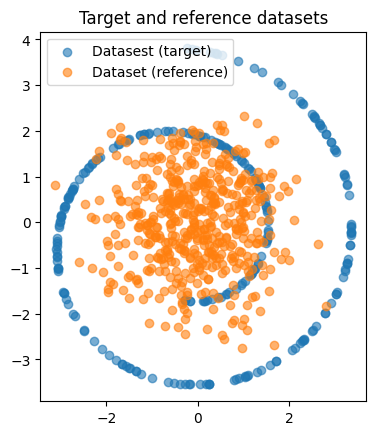

In [ ]:
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn import datasets


def load_twodim(num_samples: int,
                dataset: str,
                dimension=2) -> np.ndarray:
    """Create the two dimensional dataset array.

    Args:
        num_samples (int): number of samples.
        dataset (str): identifier of the dataset.

    Returns:
        sample (np.ndarray): (num_samples, 2) array of samples.
    """

    if dataset == 'gaussian_centered':
        if type(dimension)==int:
          sample = np.random.randn(num_samples, dimension)
        else:
          sample = np.random.randn(num_samples, dimension[0], dimension[1])

        sample = sample

    if dataset == 'gaussian_shift':
        sample = np.random.randn(num_samples, 2)
        sample = sample + 1.5

    if dataset == 'circle':
        X, y = datasets.make_circles(
            n_samples=num_samples, noise=0.0, random_state=None, factor=.5)
        sample = X * 4

    if dataset == 'scurve':
        X, y = datasets.make_s_curve(
            n_samples=num_samples, noise=0.0, random_state=None)
        init_sample = X[:, [0, 2]]
        scaling_factor = 2
        sample = (init_sample - init_sample.mean()) / \
            init_sample.std() * scaling_factor


    if dataset == 'swiss_roll':
        X, y = datasets.make_swiss_roll(
            n_samples=num_samples, noise=0.0, random_state=None)
        init_sample = X[:, [0, 2]]
        scaling_factor = 2
        sample = (init_sample - init_sample.mean()) / \
            init_sample.std() * scaling_factor




    return sample


class TwoDimDataClass(Dataset):
    """Create the two dimensional dataset.

    Args:
        dataset_type (str): identifier of the dataset.
        N (int): number of samples.
        batch_size (int): batch size.
    """

    def __init__(self,
                 dataset_type: str,
                 N: int,
                 batch_size: int,
                 dimension = 2
                 ):

        self.X = load_twodim(N, dataset_type, dimension=dimension)
        self.name = dataset_type
        self.batch_size = batch_size
        self.dimension = 2

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]

    def get_dataloader(self, shuffle=True):
        return DataLoader(
            self,
            batch_size=self.batch_size,
            shuffle=shuffle,
            collate_fn=numpy_collate,
            pin_memory=True,
        )


target_ds = TwoDimDataClass(dataset_type='swiss_roll',
                              N=1000000,
                              batch_size=256)

reference_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                              N=1000000,
                              batch_size=256)
target_loader= target_ds.get_dataloader()

Ntest = 500
sample_f = next(iter(target_loader))[:Ntest]
sample_b = reference_ds[0:Ntest]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample_f[:, 0], sample_f[:, 1], alpha=0.6)
ax.scatter(sample_b[:, 0], sample_b[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and reference datasets"
ax.set_title(strtitle)
ax.legend(['Datasest (target)', 'Dataset (reference)'])

### Creating the Ornstein-Uhlenbeck process

Back to the [top](#training-diffusion-models)!

The forward process is given by

$\mathrm{d} \mathbf{X}_t = - (1/2) \mathbf{X}_t \mathrm{d} t + \mathrm{d} \mathbf{B}_t, \qquad \mathbf{X}_0 \sim \pi \; .$

This process is known as the *Ornstein-Uhlenbeck* process and possesses a lot of appealing properties (geometric ergodicity, explicit transition kernel, explicit diagonalization basis etc.). In what follows, we create a `SDE` object. The most important method of `SDE` is `reverse` which creates the backward SDE associated with the current SDE. For example in our case, given the class associated with $(\mathbf{X}_t)_{t \in [0,T]}$ `reverse` would return the class associated with

$\mathrm{d} \mathbf{Y}_t = \{ (1/2) \mathbf{Y}_t  + \nabla \log p_{T-t}(\mathbf{Y}_t)\}\mathrm{d} t + \mathrm{d} \mathbf{B}_t, \qquad \mathbf{Y}_0 \sim \pi_T \; ,$


In [ ]:
import abc
from typing import Any
import jax.numpy as jnp
import jax

class SDE(abc.ABC):
    """SDE abstract class. Functions are designed for a mini-batch of inputs.

    Args:
      beta_schedule (Any): Schedule used for the SDE.
      N (int): Number of discretization time steps.
    """

    def __init__(self,
                 N: int):
        super().__init__()
        self.N = N

    @property
    @abc.abstractmethod
    def T(self):
        """End time of the SDE."""
        pass

    @abc.abstractmethod
    def sde_coeff(self, t, x):
        pass

    @abc.abstractmethod
    def marginal_prob(self, t, x):
        """Parameters to determine the marginal distribution of the SDE, $p_t(x)$."""
        pass

    @abc.abstractmethod
    def prior_sampling(self, rng, shape):
        """Generate one sample from the prior distribution, $p_T(x)$."""
        pass

    def reverse(self,
                model: Any,
                params: Any) -> Any:
        """Create the reverse-time SDE/ODE.

        Args:
          model (Any): the network used (see config/network).
          params (Any): the parameters of the networks.

        Returns:
          sde_backward (Any): the backward SDE.
        """
        N = self.N
        T = self.T
        sde_coeff = self.sde_coeff

        def get_model_fn(model, params):
            key = jax.random.PRNGKey(0)
            def model_fn(t, x):
                return model.apply(params, key, t, x)
            return model_fn
        # NOTE: model_fn parameterizes the score.

        def get_reverse_drift_fn(model_fn):
            def reverse_drift_fn(t, x):

                drift, diffusion = sde_coeff(self.T-t, x)
                score = model_fn(self.T-t, x)
                reverse_drift = - drift + batch_mul(diffusion ** 2, score)
                return reverse_drift
            return reverse_drift_fn

        # Build the class for reverse-time SDE.

        class RSDE(self.__class__):
            def __init__(self):
                self.N = N
                self.param_drift = 'score'
                self.model_fn = get_model_fn(model, params)
                self.reverse_drift_fn = get_reverse_drift_fn(self.model_fn)

            @property
            def T(self):
                return T

            def sde_coeff(self, t, x):
                """Create the drift and diffusion functions for the reverse SDE/ODE."""
                _, diffusion = sde_coeff(self.T-t, x)
                drift = self.reverse_drift_fn(t, x)
                return drift, diffusion

        sde_backward = RSDE()
        return sde_backward

Based on the general class `SDE` we are now going to build a SDE based on the Ornstein-Uhlenbeck process.

Recall that the Ornstein-Uhlenbeck (also called VP-SDE) is defined by
$$ \mathrm{d} \mathbf{X}_t = - (1/2) \mathbf{X}_t \mathrm{d} t + \mathrm{d} \mathbf{B}_t$$

Given $\mathbf{X}_0$ and $t$ we can sample $\mathbf{X}_t$ using that (in distribution) we have

$$\mathbf{X}_t = \exp[-t] \mathbf{X}_0 + (1 - \exp[-2t])^{1/2} Z,$$

with $Z \sim \mathcal{N}(0, \mathrm{Id})$.



In [ ]:
class OrnsteinUhlenbeck(SDE):
    def __init__(self,
                 N=100):
        """Construct an Ornstein-Uhlenbeck SDE."""

        super().__init__(N)
        self.N = N

    @property
    def T(self):
        return 1

    def sde_coeff(self, t, x):
        drift = -0.5 * x
        diffusion = jnp.ones(x.shape)
        return drift, diffusion

    def marginal_prob(self, t, x):
        log_mean_coeff = -0.5 * t
        mean = batch_mul(jnp.exp(log_mean_coeff), x)
        std = batch_mul(jnp.sqrt(1 - jnp.exp(2. * log_mean_coeff)), x*0+1)
        return mean, std

    def prior_sampling(self, key, shape):

        return jax.random.normal(key, shape)


sde = OrnsteinUhlenbeck()


### Investigating the forward diffusion

Back to the [top](#creating-datasets)!

We can now visualize a few trajectories from the Ornstein-Uhlenbeck process $\mathrm{d} \mathbf{X}_t = - (1/2) \mathbf{X}_t \mathrm{d} t + \mathrm{d} \mathbf{B}_t$. Similarly, we can also plot the mean and standard deviation of the forward trajectories which should converge to $0$, respectively $1$.

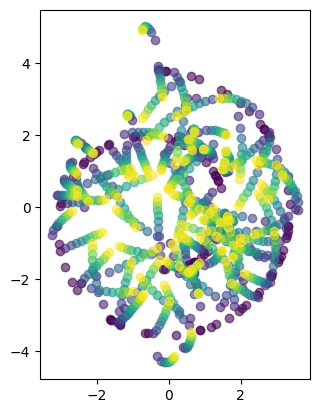

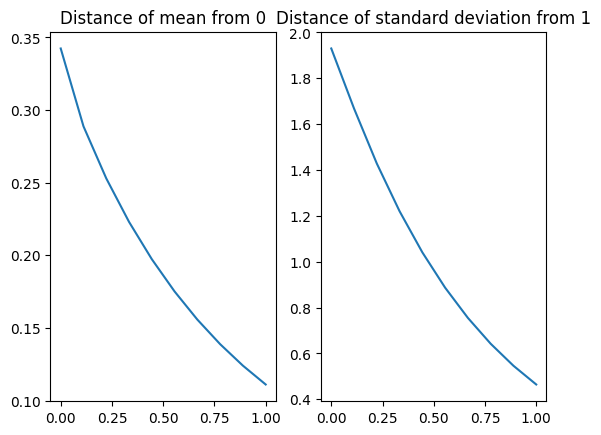

In [ ]:
cmap = plt.get_cmap('viridis')

n_arr = 10
plot_Ntest = 100

t_arr = jnp.linspace(0, sde.T, n_arr)
mean_arr = jnp.zeros((n_arr, 1))
std_arr = jnp.zeros((n_arr, 1))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for k, tt in enumerate(t_arr):
    x0 = target_ds.__getitem__(range(plot_Ntest))
    t = jnp.zeros((x0.shape[0],)) + tt
    mean, std = sde.marginal_prob(t, x0)
    key = jax.random.PRNGKey(0)
    z = jax.random.normal(key, mean.shape)
    xt = mean + batch_mul(std, z)

    mean_arr = mean_arr.at[k].set(jnp.sum(xt.mean(axis=0)**2))
    std_arr = std_arr.at[k].set(
        jnp.sum((xt.std(axis=0) - 1)**2))

    ax.scatter(xt[:, 0], xt[:, 1], alpha=0.6, color=cmap(tt))

ax.grid(False)
ax.set_aspect('equal', adjustable='box')

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
plt.plot(t_arr, jnp.abs(mean_arr))
plt.title("Distance of mean from 0")
ax.grid(False)
ax = fig.add_subplot(1, 2, 2)
plt.plot(t_arr, std_arr)
plt.title("Distance of standard deviation from 1")
ax.grid(False)

In [ ]:
!pip install jax jaxlib
!pip install git+https://github.com/deepmind/dm-haiku

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-tchxwnyp
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-tchxwnyp
  Resolved https://github.com/deepmind/dm-haiku to commit ea820a69baecb67facd0dd4958ef01cce0833c1e
  Preparing metadata (setup.py) ... done


### Creating the model, loss and optimizer

Back to the [top](#creating-datasets)!

Then, we instantiate the model which is going to be used to approximate the score $\nabla \log p_t$. Since, we are considering a low dimensional example, we simply transform the spatial and temporal input using Multi Layer Perceptron (MLP) (note that we get embedding for the time input using positional encoding). We then concatenate these embeddings and apply another layer of MLP.



In [ ]:
from typing import Any
import math
from dataclasses import dataclass
import haiku as hk
import jax.nn as jnn
import jax.numpy as jnp


def get_timestep_embedding(timesteps: jnp.ndarray,
                           embedding_dim: int,
                           max_positions=10000) -> jnp.ndarray:
    """ Get timesteps embedding.
    Function extracted from https: // github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py

    Args:
        timesteps (jnp.ndarray): timesteps array (Nbatch,).
        embedding_dim (int): Size of the embedding.
        max_positions (int, optional): _description_. Defaults to 10000.

    Returns:
        emb (jnp.ndarray): embedded timesteps (Nbatch, embedding_dim).
    """
    assert len(timesteps.shape) == 1
    half_dim = embedding_dim // 2
    # magic number 10000 is from transformers
    emb = math.log(max_positions) / (half_dim - 1)
    # emb = math.log(2.) / (half_dim - 1)
    emb = jnp.exp(jnp.arange(half_dim, dtype=jnp.float32) * -emb)
    # emb = tf.range(num_embeddings, dtype=jnp.float32)[:, None] * emb[None, :]
    # emb = tf.cast(timesteps, dtype=jnp.float32)[:, None] * emb[None, :]
    emb = timesteps[:, None] * emb[None, :]
    emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = jnp.pad(emb, [[0, 0], [0, 1]])
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb

@dataclass
class MLP:
    hidden_shapes: list
    output_shape: list
    bias: bool = True

    def __call__(self, x):
        for hs in self.hidden_shapes:
            x = hk.Linear(output_size=hs, with_bias=self.bias)(x)
            x = jnp.sin(x)

        x = hk.Linear(output_size=self.output_shape)(x)

        return x


class Naive(hk.Module):
    """Create a naive MLP network.

    Args:
        output_shape (int): output shape.
        enc_shapes (int): The shapes of the encoder.
        t_dim (int): the dimension of the time embedding.
        dec_shapes (int): The shapes of the decoder
        resnet (bool): if True then the network is a resnet.
    """

    def __init__(
        self,
        output_shape: int,
        enc_shapes: int,
        t_dim: int,
        dec_shapes: int,
    ):
        super().__init__()
        self.temb_dim = t_dim
        t_enc_dim = t_dim * 2

        self.net = MLP(hidden_shapes=dec_shapes,
                       output_shape=output_shape)

        self.t_encoder = MLP(
            hidden_shapes=enc_shapes, output_shape=t_enc_dim
        )

        self.x_encoder = MLP(
            hidden_shapes=enc_shapes, output_shape=t_enc_dim
        )

    def __call__(self, t, x):
        t = jnp.array(t, dtype=float)
        if len(x.shape) == 1:
            x = x.unsqueeze(0)

        temb = get_timestep_embedding(t.reshape(-1), self.temb_dim)
        temb = self.t_encoder(temb)
        xemb = self.x_encoder(x)
        temb = jnp.broadcast_to(temb, [xemb.shape[0], *temb.shape[1:]])
        h = jnp.concatenate([xemb, temb], -1)
        out = -self.net(h)
        return out


def init_model(key, batch_size=64, dimension=2):
    """ Initialize a model. """
    def forward(t, x):
        model = Naive(output_shape=dimension,
                    enc_shapes=[32, 32],
                    t_dim=16,
                    dec_shapes=[32,32])
        return model(t, x)
    model = hk.transform(forward)

    input_shape = (batch_size, dimension)
    t_shape = (batch_size, 1)
    dummy_t = jnp.zeros(t_shape)
    dummy_input = jnp.zeros(input_shape)

    init_params = model.init(key, t=dummy_t, x=dummy_input)
    return model, init_params

key = jax.random.PRNGKey(0)
model, init_params = init_model(key, batch_size=target_ds.batch_size, dimension=2)

Once the model is instantiated we are ready to initialize the optimizer and the loss.


In [ ]:
import optax

class DSMLoss():
    """Compute the Denoising Score Matching loss.

    Args:
        alpha (float): regularization parameter.
        sde (Any): SDE object.
        diff_weight (bool): whether to weight the loss by the diffusion.
    """

    def __init__(self,
                 alpha: float,
                 diff_weight: bool):
        self.alpha = alpha
        self.diff_weight = diff_weight

    def loss_fn(self, params, key, model, batch):
        t, xt, pred, diffusion_sq = batch

        out = model.apply(params, key, t, xt).squeeze()
        l2loss = optax.l2_loss(out, pred.squeeze())
        reg = out ** 2
        loss = l2loss + self.alpha * reg
        if self.diff_weight:
            loss = loss / diffusion_sq.squeeze()
        loss = jnp.mean(loss)
        return loss

loss_fn = DSMLoss(alpha=0, diff_weight=False).loss_fn
optimizer = optax.adam(learning_rate=1e-3, b1=.9, b2=0.999, eps=1e-8)

Finally, we define the updating step `step_fn` to be used in the training loop.

We write the batch to be given to `loss_fn`. This batch `batch_tot` is composed of
* `t`: a time randomly sampled between $\varepsilon$ and $1$ (you can pick the value of $\varepsilon$)
* `xt`: the value of $\mathbf{X}_t$ given one element of the batch `batch` (corresponding to $\mathbf{X}_0$) and a time `t`.
* `pred`: the value to be predicted in the loss. This corresponds to $\nabla \log p_{t|0}(\mathbf{X}_t|\mathbf{X}_0)$ where $p_{t|0}$ is the distribution of $\mathbf{X}_t|\mathbf{X}_0$.
* `diffusion_sq`: the square of the diffusion coefficients (only used if we rescaled the loss, so can be omitted at first read).

In [ ]:
def get_step_fn(loss_fn: Any,
                optimizer: Any,
                sde: Any,
                model: Any) -> Any:
    """Create one step of optimization.

    Args:
        loss_fn (Any): The loss function (see config/loss).
        optimizer (Any): The optimizer (see config/optim).
        model (Any): The neural network (see config/network).

    Returns:
        step_fn (Any): The learning state function.
    """

    def step_fn(key: jax.random.KeyArray,
                state: Any,
                batch: Any) -> Any:
        """Apply one step of optimization

        Args:
            key (jax.random.KeyArray): random key
            state (Any): training state
            batch (Any): batch of data

        Returns:
            state (Any): updated training state.
        """
        key, step_key = jax.random.split(key)

        batch_shape = batch.shape[0]
        t = jax.random.uniform(key, minval=1e-3, maxval=sde.T, shape=(batch_shape,1))
        mean, std = sde.marginal_prob(t, batch)
        _, diffusion = sde.sde_coeff(t, batch)
        diffusion_sq = diffusion ** 2
        z = np.random.normal(size=mean.shape)
        xt = mean + batch_mul(std, z)
        pred = - z / std
        batch_tot = (t, xt, pred, diffusion_sq)

        params = state.params
        loss, grad = jax.value_and_grad(loss_fn)(
            params, step_key, model, batch_tot)
        update, new_opt_state = optimizer.update(grad, state.opt_state)
        new_params = optax.apply_updates(params, update)

        new_params_ema = jax.tree_map(
            lambda p_ema, p: p_ema * state.ema_rate
            + p * (1.0 - state.ema_rate),
            state.params_ema,
            new_params,
        )
        step = state.step + 1
        new_state = state.replace(step=step+1,
                                  opt_state=new_opt_state,
                                  params=new_params,
                                  params_ema=new_params_ema)

        return new_state, loss, key
    return step_fn


step_fn = get_step_fn(loss_fn, optimizer, sde, model)


<ipython-input-110-781eea643077>:16: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def step_fn(key: jax.random.KeyArray,


### Training the model

Back to the [top](#creating-datasets)!

We can now instantiate the `DiffusionState` object which keeps track of all the information related to the SDE we consider.

In [ ]:
import flax

@flax.struct.dataclass
class DiffusionState:
    dataclass: Any
    step_fn: Any

diffusion = DiffusionState(dataclass=target_ds,
                             step_fn=step_fn)


@flax.struct.dataclass
class State:
    step: int
    opt_state: Any
    params: Any
    ema_rate: float
    params_ema: Any


step = 0
opt_state = optimizer.init(init_params)
params = init_params
params_ema = init_params

state = State(step=step,
              opt_state=opt_state,
              params=params,
              ema_rate=0.99,
              params_ema=params_ema)


We write the training loop in `train_diffusion`. Note that you can use `jax.jit(diffusion.step_fn)` to compile one training step and greatly improve the speed of the code.

In [ ]:
from tqdm import tqdm

def train_diffusion(diffusion, state, steps_total):

    dataclass = diffusion.dataclass
    step_fn = jax.jit(diffusion.step_fn)

    trange = tqdm(
        range(0, steps_total),
        bar_format="{desc}{bar}{r_bar}",
        mininterval=1,
        )
    dataloader = dataclass.get_dataloader()
    diff_iter = iter(repeater(dataloader))
    key = jax.random.PRNGKey(0)

    for step in trange:
        batch = next(diff_iter)
        state, loss, key = step_fn(key, state, batch)
        if step % 500 == 0:
            trange.set_description(
                "Loss: {:.3f}".format(loss))
    return state

steps_total = 10000
state = train_diffusion(diffusion, state, steps_total)

Loss: 2.464: ██████████| 10000/10000 [00:50<00:00, 196.72it/s]


### Sampling from the model

Back to the [top](#creating-datasets)!

Once the model is trained we can sample approximately from the backward SDE

$\mathrm{d} \mathbf{Y}_t = \{(1/2) \mathbf{Y}_t + \nabla \log p_{T-t}(\mathbf{Y}_t)\}\mathrm{d} t + \mathrm{d} \mathbf{B}_t, \qquad \mathbf{Y}_0 \sim \pi_T, $

In [ ]:
from typing import Any
import jax
import jax.numpy as jnp
import jax.random as random
import abc

class Predictor(abc.ABC):
    """The abstract class for a predictor algorithm."""

    def __init__(self, sde):
        super().__init__()
        self.sde = sde

    @abc.abstractmethod
    def update_fn(self,
                  key: jax.random.KeyArray,
                  t: jnp.ndarray,
                  x: jnp.ndarray) -> Any:
        """One update of the predictor.

        Args:
          key (jax.random.KeyArray): A JAX random state.
          t (jnp.ndarray): A JAX array representing the current time step.
          x (jnp.ndarray): A JAX array representing the current state

        Returns:
          x (jnp.ndarray): A JAX array of the next state.
          x_mean (jnp.ndarray): A JAX array. The next state without random noise. Useful for denoising.
          pred (jnp.ndarray): a JAX array. The prediction used in the loss function.
        """
        pass

class EulerMaruyamaPredictor(Predictor):
    def __init__(self, sde):
        super().__init__(sde)
        self.param_drift = self.sde.param_drift

    def update_fn(self, key, t, x):
        dt = 1. / self.sde.N
        z = random.normal(key, x.shape)
        drift, diffusion = self.sde.sde_coeff(t, x)
        x_mean = x + dt * drift
        x = x_mean + batch_mul(diffusion, jnp.sqrt(dt) * z)
        return x, x_mean

class Sampler():
    """Create a sampling class.

    Args:
      eps (float): A float representing the epsilon stopping time for the backward diffusion.
    """

    def __init__(self,
                 eps: float):

        self.eps = eps

    def get_sampling_fn(self,
                        sde: Any,
                        dataset: Any) -> Any:
        """Create a sampling function.

        Args:
          sde (Any): An SDE.
          dataset (Any): The dataset associated with this SDE (initialization).

        Returns:
          sampling_fn (Any): A sampling function which takes as input a random key and a number of samples.
        """

        update_fn = EulerMaruyamaPredictor(sde).update_fn

        def sampling_fn(key: jax.random.KeyArray, N_samples: int) -> Any:
            """_summary_

            Args:
                key (jax.random.KeyArray): A JAX random state.
                N_samples (int): The number of samples.

            Returns:
                out (jnp.ndarray): the last sample of the SDE (N_samples, dimension).
                ntot (int): the total number of steps of the sampling procedure.
                timesteps (jnp.ndarray): the timesteps of the sampling procedure.
                x_hist (jnp.ndarray): the total history of the SDE (N, N_samples, dimension) (N is the number of timesteps).
                pred_hist (jnp.ndarray): the total history of the predictions of the SDE (N, N_samples, dimension) (N is the number of timesteps).
            """
            # Initial sample
            x = dataset.__getitem__(range(N_samples))
            timesteps = jnp.linspace(0, sde.T-self.eps, sde.N)

            def loop_body(i, val):
                key, x, x_mean, x_hist = val
                t = timesteps[i]
                vec_t = jnp.ones((x.shape[0], 1)) * t
                key, step_key = random.split(key)
                x, x_mean = update_fn(step_key, vec_t, x)
                x_hist = x_hist.at[i].set(x)
                return key, x, x_mean, x_hist

            # Get shape for predictions update
            t = jnp.ones((x.shape[0], 1))

            x_hist = jnp.zeros((sde.N, *x.shape))
            _, x, _, x_hist = jax.lax.fori_loop(
                0, sde.N, loop_body, (key, x, x, x_hist))
            out = x
            ntot = sde.N
            return out, ntot, timesteps, x_hist

        return sampling_fn


sde_backward = sde.reverse(model, state.params_ema)
sampler = Sampler(eps=1e-3)
sampler_fn = sampler.get_sampling_fn(sde_backward, reference_ds)

out, ntot, timesteps, x_hist = sampler_fn(key, N_samples=100)

<ipython-input-113-2fbb0998d4d6>:16: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  key: jax.random.KeyArray,
<ipython-input-113-2fbb0998d4d6>:73: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def sampling_fn(key: jax.random.KeyArray, N_samples: int) -> Any:


Text(0.5, 1.0, 'Final backward particles')

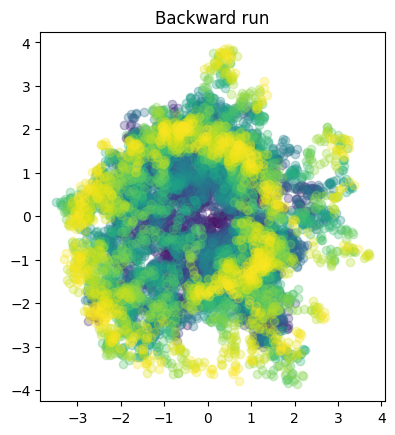

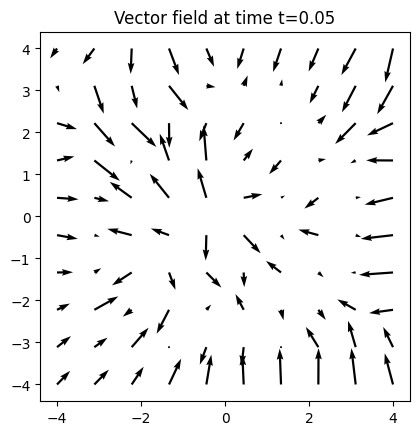

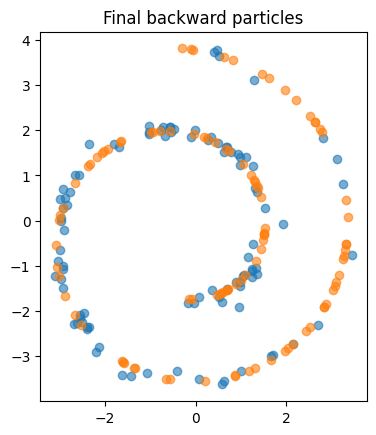

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
t_arr = jnp.linspace(0, 1, plot_Ntest)
for k, tt in enumerate(t_arr):
    outk = x_hist[k]
    ax.scatter(outk[:, 0], outk[:, 1], alpha=0.3, color=cmap(tt))
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Backward run"
ax.set_title(strtitle)

xmin, xmax = -4, 4
ymin, ymax = -4, 4
xx, yy = jnp.mgrid[xmin:xmax:10j, ymin:ymax:10j]
fig = plt.figure()
t0 = 0.05
x = jnp.concatenate(
    (xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=-1)
t = jnp.zeros((x.shape[0],)) + t0
out = model.apply(state.params_ema, key, t, x)
u = out[:, 0].reshape(xx.shape)
v = out[:, 1].reshape(yy.shape)
ax = fig.add_subplot(1, 1, 1)
ax.quiver(xx, yy, u, v)
ax.set_aspect('equal', adjustable='box')
strtitle = "Vector field at time t=0.05"
ax.set_title(strtitle)

out_true = target_ds[range(0, plot_Ntest)]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x_hist[-1, :, 0], x_hist[-1, :, 1], alpha=0.6)
ax.scatter(out_true[:, 0], out_true[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Final backward particles"
ax.set_title(strtitle)

### Onto image datasets

Back to the [top](#creating-datasets)!

In [ ]:
import torchvision
from torchvision import transforms
import torch

transforms_list = [
    transforms.Pad(2, fill=0),  # left and right 2+2=4 padding
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
]

mnist_ds = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transforms.Compose(transforms_list))
images = np.array(torch.cat([mnist_ds[i][0] for i in range(1000)]))


In [ ]:
# Compute mean and std

mean, std = images.mean(), images.std()
print(f'Mean: {mean:.3f}, Standard Deviation: {std:.3f}')

Mean: -0.804, Standard Deviation: 0.545


In [ ]:
class ImageDataClass(Dataset):
    """Create a flatten image dataset.

    Args:
        dataset_type (str): identifier of the dataset.
        N (int): number of samples.
        batch_size (int): batch size.
    """

    def __init__(self,
                 image_ds: Any,
                 batch_size: int,
                 mean: float = 0.,
                 std: float = 1.):

        self.image_ds = image_ds
        self.batch_size = batch_size

    def __len__(self):
        return self.image_ds.__len__()

    def __getitem__(self, idx):
        return ((self.image_ds.__getitem__(idx)[0].numpy() - mean) / std).transpose(1, 2, 0)

    def get_dataloader(self, shuffle=True):
        return DataLoader(
            self,
            batch_size=self.batch_size,
            shuffle=shuffle,
            collate_fn=numpy_collate,
            pin_memory=True,
        )


image_ds = ImageDataClass(mnist_ds, batch_size=128, mean=mean, std=std)


In [ ]:
class TimeEmbedding(hk.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def __call__(self, time):
        half_dim = self.dim // 2
        embeddings = jnp.log(10000) / (half_dim - 1)
        embeddings = jnp.exp(jnp.arange(half_dim) * -embeddings)
        embeddings = time[:, jnp.newaxis] * embeddings[jnp.newaxis, :]
        embeddings = jnp.concatenate(
            (jnp.sin(embeddings), jnp.cos(embeddings)), axis=-1
        )
        return embeddings

class Block(hk.Module):
    def __init__(self, dim_out, groups=8):
        super().__init__()
        self.proj = hk.Conv2D(dim_out, kernel_shape=3, padding=(1, 1))
        self.norm = hk.GroupNorm(groups)
        self.act = jax.nn.silu

    def __call__(self, x):
        x = self.proj(x)
        x = self.norm(x)
        x = self.act(x)
        return x


class ResnetBlock(hk.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim_out, groups=8, change_dim=False):
        super().__init__()
        self.mlp = hk.Sequential([jax.nn.silu, hk.Linear(dim_out)])
        self.block1 = Block(dim_out, groups=groups)
        self.block2 = Block(dim_out, groups=groups)
        self.res_conv = (
            hk.Conv2D(dim_out, kernel_shape=1, padding=(0, 0))
            if change_dim
            else lambda x: x
        )

    def __call__(self, x, time_emb):
        h = self.block1(x)
        time_emb = self.mlp(time_emb)
        # We add new axes to the time embedding to for broadcasting.
        h = time_emb[:, jnp.newaxis] + h
        h = self.block2(h)
        return h + self.res_conv(x)


def SpatialUpsample(dim):
    return hk.Conv2DTranspose(dim, kernel_shape=4, stride=2)


def SpatialDownsample(dim):
    return hk.Conv2D(dim, kernel_shape=4, stride=2, padding=(1, 1))


class Unet(hk.Module):
    def __init__(
        self,
        dim,
        dim_mults=(1,),
        channels=1,
        resnet_block_groups=1,
    ):
        super().__init__()

        # determine dimensions
        init_dim = dim // 3 * 2
        self.init_conv = hk.Conv2D(init_dim, kernel_shape=7, padding=(3, 3))

        # time embeddings
        time_dim = dim * 4
        self.time_mlp = hk.Sequential(
            [
                TimeEmbedding(dim),
                hk.Linear(time_dim),
                jax.nn.gelu,
                hk.Linear(time_dim),
            ]
        )

        # layers
        self.downs = []
        dims = list(map(lambda m: dim * m, dim_mults))

        for ind, stage_dim in enumerate(dims):
            is_last = ind >= len(dims) - 1

            self.downs.append(
                [
                    ResnetBlock(
                        stage_dim, groups=resnet_block_groups, change_dim=True),
                    ResnetBlock(stage_dim, groups=resnet_block_groups),
                    # We don't apply spatial downsampling to the last stage. This is
                    # because we go from 28x28 -> 14x14 -> 7x7 in the 1st and 2nd
                    # stages and 7 can't be halved without a remainder, which
                    # would cause problems in the upsampling path.
                    SpatialDownsample(
                        stage_dim) if not is_last else lambda x: x,
                ]
            )

        mid_dim = dims[-1]
        self.mid_block1 = ResnetBlock(mid_dim, groups=resnet_block_groups)
        self.mid_block2 = ResnetBlock(mid_dim, groups=resnet_block_groups)

        self.ups = []
        rev_dims = list(reversed(dims))
        for ind, stage_dim in enumerate(rev_dims):
            is_last = ind >= len(rev_dims) - 1

            self.ups.append(
                [
                    ResnetBlock(
                        stage_dim, groups=resnet_block_groups, change_dim=True),
                    ResnetBlock(stage_dim, groups=resnet_block_groups),
                    SpatialUpsample(stage_dim) if not is_last else lambda x: x,
                ]
            )

        self.final_block = ResnetBlock(dim, groups=resnet_block_groups)
        self.final_conv = hk.Conv2D(channels, kernel_shape=1, padding=(0, 0))

    def __call__(self, time, x):
        x = self.init_conv(x)
        t = self.time_mlp(time)

        h = []
        # downsample
        for block1, block2, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            h.append(x)
            x = downsample(x)


        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, upsample in self.ups:
            x = jnp.concatenate((x, h.pop()), axis=-1)
            x = block1(x, t)
            x = block2(x, t)
            x = upsample(x)

        x = self.final_block(x, t)
        return self.final_conv(x)

In [ ]:
def init_model(key, batch_size=16, dimension=32):
    """ Initialize a model. """
    def forward(t, x):
        model = Unet(dim=32)
        return model(t, x)
    model = hk.transform(forward)

    input_shape = (batch_size, dimension, dimension, 1)
    t_shape = (batch_size, 1)
    dummy_t = jnp.zeros(t_shape)
    dummy_input = jnp.zeros(input_shape)

    init_params = model.init(key, t=dummy_t, x=dummy_input)
    return model, init_params

In [ ]:
key = jax.random.PRNGKey(0)
sde = OrnsteinUhlenbeck(N=1000)
model, init_params = init_model(key, batch_size=image_ds.batch_size, dimension=32)
loss_fn = DSMLoss(alpha=0, diff_weight=False).loss_fn
optimizer = optax.adam(learning_rate=1e-4, b1=.9, b2=0.999, eps=1e-8)
step_fn = get_step_fn(loss_fn, optimizer, sde, model)

@flax.struct.dataclass
class DiffusionState:
    dataclass: Any
    step_fn: Any

diffusion = DiffusionState(dataclass=image_ds,
                             step_fn=step_fn)


@flax.struct.dataclass
class State:
    step: int
    opt_state: Any
    params: Any
    ema_rate: float
    params_ema: Any


step = 0
opt_state = optimizer.init(init_params)
params = init_params
params_ema = init_params

state = State(step=step,
              opt_state=opt_state,
              params=params,
              ema_rate=0.99,
              params_ema=params_ema)

<ipython-input-110-781eea643077>:16: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def step_fn(key: jax.random.KeyArray,


In [ ]:
steps_total = 10
state = train_diffusion(diffusion, state, steps_total)

Loss: 4.724: ██████████| 10/10 [01:35<00:00,  9.55s/it]


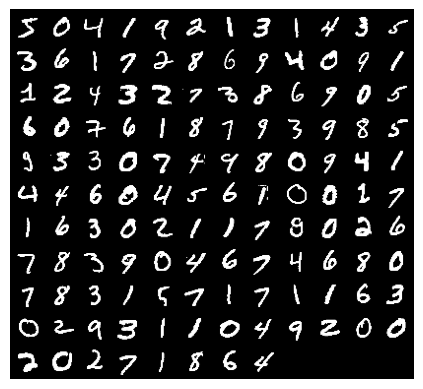

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

dataloader = image_ds.get_dataloader(shuffle=False)

original = next(iter(dataloader)).reshape(-1, 1, 32, 32)
noised = original * np.exp(-1) + np.random.normal(0, 1, original.shape) * np.sqrt(1 - np.exp(-2))

images_original = torch.tensor(original.reshape(-1, 1, 32, 32))
images_noised = torch.tensor(noised.reshape(-1, 1, 32, 32))

def show_image_grid(images, nrow=8, padding=2,
                    normalize=False, range=None, scale_each=False, pad_value=0):
    """Imshow for Tensor."""
    from torchvision.utils import make_grid
    grid = make_grid(images, nrow=nrow, padding=padding,
                     normalize=normalize, scale_each=scale_each, pad_value=pad_value)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')


show_image_grid(images_original, nrow=12, padding=2)

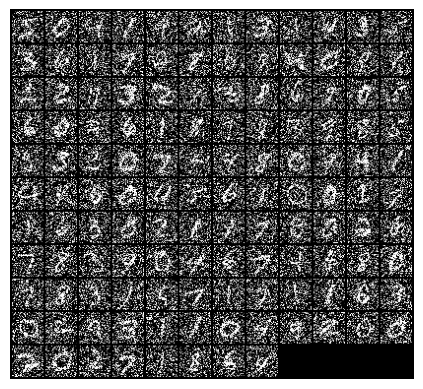

In [ ]:
show_image_grid(images_noised, nrow=12, padding=2)

In [ ]:
reference_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                              N=500,
                              dimension=(32,32),
                              batch_size=256)

sde_backward = sde.reverse(model, state.params_ema)
sampler = Sampler(eps=1e-3)
sampler_fn = sampler.get_sampling_fn(sde_backward, reference_ds)

out, ntot, timesteps, x_hist = sampler_fn(key, N_samples=128)

<ipython-input-113-2fbb0998d4d6>:73: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def sampling_fn(key: jax.random.KeyArray, N_samples: int) -> Any:


ValueError: 'unet/~/conv2_d/w' with retrieved shape (7, 7, 1, 20) does not match shape=(7, 7, 32, 20) dtype=dtype('float32')

In [ ]:
images = torch.tensor(np.array(x_hist[-1].reshape(-1, 1, 32, 32)))
show_image_grid(images, nrow=12, padding=2)

In [ ]:
import session_info

session_info.show()